# Method - 1

In this method we have first found the background image by using a number of frames from the video. In our problem, the base (where the material is being deposited) is having relative motion, while the rest of the things (i.e.the nozzle etc) are static. 
The idea is to find the template of the base in the image and perform the subtraction wherever it matches to the test image, and subtract the all other corresponding pixel values from the background image pixels. This results in an image with the foreground, where first cleaning is done using some filters and applied Hough's method to detect the circles.

Below code is for processing a single frame from the video. Here I have vectorized the 'for loop' for subtraction which was rather slow in the earlier version.

`circles = cv2.HoughCircles(median, cv2.HOUGH_GRADIENT, 1, median.shape[0]/30, param1=60, param2=10,minRadius=5, maxRadius=20)`

The parameters (i.e. min and max radius and the min seperation between the circles) for this method have been set by hit and trial by careful observation of the several frames.

top_left (780, 822)
bottom_right (1680, 1077)
center     radius
[[[1350  842   10]
  [1214  992    6]
  [1336  734   10]
  [1208  816   10]
  [1538  714   16]
  [1592  816   12]
  [1144  766   19]
  [1102  822    7]
  [1398  772    9]
  [1332  810   12]
  [1262  822    9]
  [1100  782   10]
  [ 644  980    6]
  [1678  908    6]]]


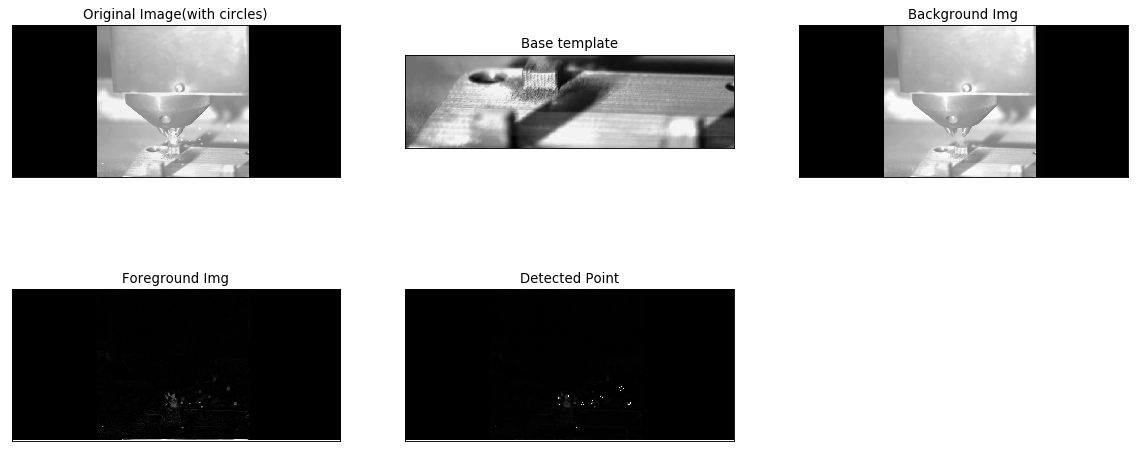

In [2]:
"""
This code uses finds base template and subtracts it from the image after searching it in the main image.
The remaining pixel values are subtracted using the background template.

References:
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_template_matching/py_template_matching.html
https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=houghcircles
"""

import cv2
import numpy as np
from matplotlib import pyplot as plt

# input.jpg is the image in which the detection is to done
img = cv2.imread('images/input.jpg',0)
# storing original image 
oImg = img.copy()
# loading the base template
template = cv2.imread('images/bTemplate.jpg',0)
# storing the dimensions of the template image
w, h = template.shape[::-1]

# Apply template Matching
res = cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

# getting the position where the template is matched
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
print("top_left", top_left)
print("bottom_right", bottom_right)
cv2.rectangle(img,top_left, bottom_right, 255, 2)

# loading the background image
bg = cv2.imread('images/bg.jpg',0)

# performing image subtraction
# subtracting the template
mast = []
mast = 2*abs(0.5*img[top_left[1]+1:bottom_right[1],top_left[0]+1:bottom_right[0]]-0.5*template[1:bottom_right[1]-top_left[1],1:bottom_right[0]-top_left[0]])
# subtracting the background
img[0:img.shape[0],0:img.shape[1]]=2*abs(0.5*img[0:img.shape[0],0:img.shape[1]]-0.5*bg[0:img.shape[0],0:img.shape[1]])
img[top_left[1]+1:bottom_right[1],top_left[0]+1:bottom_right[0]] = mast
transitImg = img

# print(template.shape)
# print(img.shape)

# removing salt and pepper noise using the median filter
img = cv2.medianBlur(img,9)
#cv2.imwrite("transit.jpg",img)

# adaptive mean thresholding
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
median = cv2.medianBlur(th2,5)

# removing noise using kernel
kernel = 2*np.ones((3,3),np.float32)
median = cv2.filter2D(median,-1,kernel)

# HoughCircles method
circles = cv2.HoughCircles(median, cv2.HOUGH_GRADIENT, 1, median.shape[0]/30, param1=60, param2=10,minRadius=5, maxRadius=20)
# drawing the circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        center = (i[0], i[1])
        # circle center
        cv2.circle(img, center, 1, (0, 100, 100), 3)
        # circle outline
        radius = i[2]
        cv2.circle(img, center, radius, (255, 255, 255), 1)
        
print("center     radius")
print(circles)
# cv2.imshow("detected circles", img)
# plt.imshow(img,"gray")
plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(231),plt.imshow(oImg,cmap = 'gray')
plt.title('Original Image(with circles)'), plt.xticks([]), plt.yticks([])
plt.subplot(232),plt.imshow(template,cmap = 'gray')
plt.title('Base template'), plt.xticks([]), plt.yticks([])
plt.subplot(233),plt.imshow(bg,cmap = 'gray')
plt.title('Background Img'), plt.xticks([]), plt.yticks([])
plt.subplot(234),plt.imshow(transitImg,cmap = 'gray')
plt.title('Foreground Img'), plt.xticks([]), plt.yticks([])
plt.subplot(235),plt.imshow(img,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

#cv2.imwrite("output.jpg",img)
plt.show()

The above method can be modified (i.e. looped) for processing the video frame by frame. The output for a fraction of video can be seen [here](https://drive.google.com/file/d/12Kc3fQ80Focmj8oF6yplkbH5YugCa4g-/view?usp=sharing).
> This method works fine but results are not that good for some of the frames, this is possibly due to not so good template matching as the base may get scaled or rotated, resulting in improper substraction. This may be rectified by using more advanced matching and subtraction after taking into account the scaling and the rotation.

## Obtaining the frames

Individual frames for further processing can be obtained using the below cell. The frames are stored in the "<parent directory>/Frames" folder.

In [ ]:
import cv2

# Opens the Video file
cap= cv2.VideoCapture('test.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite('Frames/kang'+str(i)+'.jpg',frame)
    i+=1

cap.release()
cv2.destroyAllWindows()

## Generating the video output from processed frames 

This cell reads the images from the output directory in the parent folder to generate the video.

In [ ]:
import cv2
import numpy as np
import os

from os.path import isfile, join

def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

    # #for sorting the file names properly
    # files.sort(key = lambda x: int(x[5:-4]))
    #
    for i in range(len(files)):
        filename="output/kang"+str(i)+".jpg"
        #reading each files
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        print(filename)
        #inserting the frames into an image array
        frame_array.append(img)

    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()

def main():
    pathIn= 'output/'
    pathOut = 'video.avi'
    fps = 20.0
    convert_frames_to_video(pathIn, pathOut, fps)

if __name__=="__main__":
    main()

# Method - 2 

In this method instead of generating an average background image we find a local averaged background from the video and then use that for subtraction, this will possibly counter the problem of relative motion. Suppose we are processing ith frame from the video than we can use frames i-4 to i+4 (the "4" means here we will be using 9 frames to get the local background). The below code implements this method and will process the entire video frame by frame, the 'out' folder store the foreground frames while the 'output' folder stores the frames with circle detection. These frames can be stitched into [forground video](https://drive.google.com/file/d/1Eji3wlLOKDZ93GpbLphnRYtBM2Omz-b7/view?usp=sharing) and [detection video](https://drive.google.com/file/d/1XVl5q2JXV_Z2NvhAIaeh1w5wNIwbg-zl/view?usp=sharing).

The class  `cv::BackgroundSubtractorMOG2` have been used to generate the background from the selected frames.

In [ ]:
import cv2
import numpy as np

# return the single frame at the given index
def frameGen(frameIndex):
	# check for valid frame number
    if frameIndex >= 0 & frameIndex <= totalFrames:
    	# set frame position
    	cap.set(cv2.CAP_PROP_POS_FRAMES,frameIndex)
    else:
    	print("Error: frame index out of range")

    ret, frame = cap.read()
    # cv2.imwrite("frame"+str(frameIndex)+".jpg", frame)
    return(frame)

# returns local average bacground image for a given index
def bgCalc(i):
	# number of frames for calculating the average
	windowSize = 9
	# number if frame padded to the left and right of the index i
	padding = (windowSize-1)//2
	fgbg = cv2.createBackgroundSubtractorMOG2()
	if i<padding:
		for j in range(i+8):
			fgmask=fgbg.apply(frameGen(j),learningRate=0.2)
			# fgmask=cv2.BackgroundSubtractor.apply(image[, fgmask[, learningRate]])
			bgmask=fgbg.getBackgroundImage()

	elif i>=padding and i<=totalFrames-padding:
		for j in range(i-padding,i+padding):
			fgmask=fgbg.apply(frameGen(j),learningRate=0.2)
			# fgmask=cv2.BackgroundSubtractor.apply(image[, fgmask[, learningRate]])
			bgmask=fgbg.getBackgroundImage()
			# cv2.imwrite(str(j)+".jpg",bgmask)
			# cv2.imwrite("a"+str(j)+".jpg",fgmask)

	elif i>totalFrames-padding:
		for j in range(i-8,totalFrames):
			fgmask=fgbg.apply(frameGen(j),learningRate=0.2)
			# fgmask=cv2.BackgroundSubtractor.apply(image[, fgmask[, learningRate]])
			bgmask=fgbg.getBackgroundImage()
	else:
		print("Incorrect frame index")
	return(bgmask)


def circleIdentifier(i):
    imgFrame = frameGen(i)
    img = 2*(0.5*imgFrame-0.5*bgCalc(i))
    cv2.imwrite("out/kang"+str(i)+".jpg",img)
    img=cv2.imread("out/kang"+str(i)+".jpg",0)

    # adaptive mean thresholding
    th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)

    # removing noise using kernel
    kernel = 2*np.ones((3,3),np.float32)
    median = cv2.filter2D(th2,-1,kernel)

    # HoughCircles method
    circles = cv2.HoughCircles(median, cv2.HOUGH_GRADIENT, 1, median.shape[0]/30, param1=60, param2=10,minRadius=5, maxRadius=20)

    # drawing the circles
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for k in circles[0, :]:
            center = (k[0], k[1])
            # circle center
            cv2.circle(imgFrame, center, 1, (0, 100, 100), 2)
            # circle outline
            radius = k[2]
            cv2.circle(imgFrame, center, radius, (0, 0, 0), 2)

    # print(circles)
    cv2.imwrite("output/kang"+str(i)+".jpg",imgFrame)


# capture frames from a camera
cap = cv2.VideoCapture('test.mp4')
# get total number of frames
totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

# doing the process for each frame
for i in range(int(totalFrames)):
	circleIdentifier(i)

# Counting the particles

For detecting the unique particles/circles we can compare the positions of the circles in two successive frames after setting some threshold for the distance moved. And if a new particle is encountered which not in the threshold region of the already known particles than it can be counted as new.
> Implementation is in progress